# Exploratory Data Analysis

In [1]:
# Import necessary modules
import pandas as pd
import geopandas as gpd
import plotly.express as px
import seaborn as sns

In [2]:
# Import data
df = pd.read_csv('../Data/processed_data.csv')

df.head()

REF Company Company_Location  Year_Reviewed         Bean_Origin  \
0  2454    5150           U.S.A.           2019            Tanzania   
1  2458    5150           U.S.A.           2019  Dominican Republic   
2  2454    5150           U.S.A.           2019          Madagascar   
3  2542    5150           U.S.A.           2021                Fiji   
4  2546    5150           U.S.A.           2021           Venezuela   

   Cocoa_Percent                    Characteristics  Rating  S_Bean_Origin  \
0           76.0          rich cocoa, fatty, bready    3.25   Kokoa Kamili   
1           76.0             cocoa, vegetal, savory    3.50         Zorzal   
2           76.0       cocoa, blackberry, full body    3.75  Bejofo Estate   
3           68.0                chewy, off, rubbery    3.00   Matasawalevu   
4           72.0  fatty, earthy, moss, nutty,chalky    3.00   Sur del Lago   

   Number_Ingredients  Ingredient_B  Ingredient_C  Ingredient_L  Ingredient_S  \
0                   3             1             1             0             1   
1                   3             1             1             0             1   
2                   3             1             1             0             1   
3                   3             1             1             0             1   
4                   3             1             1             0             1   

   Ingredient_S*  Ingredient_Sa  Ingredient_V  
0              0              0             0  
1              0              0             0  
2              0              0             0  
3              0              0             0  
4              0              0             0

Since a lot of the research involves comparing the results between countries, I am going to get the geodata for all countries as well. For this I'm using GeoPandas.

In [3]:
# Import geodata
geodata = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geodata

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

### 1. Average Rating by Country of Origin

In [4]:
av_rating_origin_df = df.groupby('Bean_Origin')[['Rating']].mean().reset_index().rename(columns={'Rating':'Average_Rating'})
av_rating_origin_df.sort_values(by=['Average_Rating'], inplace=True, ascending=False)

print('TOP 10 COUNTRIES\n{}\n\n'.format(av_rating_origin_df.head(10)))
print('BOTTOM 10 COUNTRIES\n{}'.format(av_rating_origin_df.tail(10)))

TOP 10 COUNTRIES
            Bean_Origin  Average_Rating
42  Sao Tome & Principe        3.500000
7                 China        3.500000
44      Solomon Islands        3.450000
9                 Congo        3.318182
53             Thailand        3.300000
61              Vietnam        3.295139
11                 Cuba        3.291667
35     Papua New Guinea        3.280612
28           Madagascar        3.273669
21                Haiti        3.266667


BOTTOM 10 COUNTRIES
              Bean_Origin  Average_Rating
49                Sumatra        3.000000
33                Nigeria        2.875000
51                 Taiwan        2.875000
45              Sri Lanka        2.875000
25            Ivory Coast        2.833333
43           Sierra Leone        2.750000
38               Principe        2.750000
30             Martinique        2.750000
47  St.Vincent-Grenadines        2.750000
39            Puerto Rico        2.714286


In [5]:
# Rename the country column to merge it later
renamed_av_rating_origin_df = av_rating_origin_df.rename(columns={'Bean_Origin':'name'})

# Merge the dataframe with the geodata
map = pd.merge(geodata, renamed_av_rating_origin_df, how='inner', on='name')

# Display the choropleth
ratings_map = map.plot(column='Average_Rating', legend=True, legend_kwds={'shrink': 0.4}, figsize=(35, 20), missing_kwds={"color": "purple"})

From the map I can see that according to the origin of the beans, chocolate bars are:
- best rated: north-east Europe
- medium rated: south of the ecuatorial
- worst rated: closest to the ecuatorial

However, the country of bean origin doesn't seem to be the most accurate way to measure the quality of the chocolate bars.

### 2. Amount of Chocolate Bars Reviewed by Country of Origin

The average ratings might be affected by the number of reviews, so I also want to check how these two variables correlate with each other.

In [6]:
# Get the number of reviews per country of origin
count_origin_df = df['Bean_Origin'].value_counts()

# Reindex and rename the columns
count_origin_df = count_origin_df.to_frame()
count_origin_df = count_origin_df.reset_index().rename({'index':'Bean_Origin', 'Bean_Origin':'Number_of_Reviews'}, axis=1)

count_origin_df

Bean_Origin  Number_of_Reviews
0               Venezuela                246
1                    Peru                231
2      Dominican Republic                217
3                 Ecuador                200
4              Madagascar                169
..                    ...                ...
57                 Tobago                  1
58  St.Vincent-Grenadines                  1
59             Martinique                  1
60                  Burma                  1
61               DR Congo                  1

[62 rows x 2 columns]

Now that I have the data, let's display some visuals.

In [7]:
# Rename the country column to merge it later
renamed_count_origin_df = count_origin_df.rename(columns={'Bean_Origin':'name'})

# Merge the dataframe with the geodata
map = pd.merge(geodata, renamed_count_origin_df, how='inner', on='name')

# Display the choropleth
ratings_map = map.plot(column='Number_of_Reviews', legend=True, legend_kwds={'shrink': 0.4}, figsize=(35, 20), missing_kwds={"color": "purple"})

I can see that most of the countries with best ratings also have the lowest number of reviews.

To understand better the relationship between ratings and number of reviews let's create the full set with the average ratings and further analyse it.

In [8]:
# Remove the index of the average ratings dataframe
av_rating_origin_df = av_rating_origin_df.reset_index(drop=True)

# Merge the dataframes
av_rating_count_origin_df = pd.merge(av_rating_origin_df, count_origin_df, how='inner', on='Bean_Origin')

av_rating_count_origin_df

Bean_Origin  Average_Rating  Number_of_Reviews
0     Sao Tome & Principe        3.500000                  2
1                   China        3.500000                  1
2         Solomon Islands        3.450000                 10
3                   Congo        3.318182                 11
4                Thailand        3.300000                  5
..                    ...             ...                ...
57           Sierra Leone        2.750000                  4
58               Principe        2.750000                  1
59             Martinique        2.750000                  1
60  St.Vincent-Grenadines        2.750000                  1
61            Puerto Rico        2.714286                  7

[62 rows x 3 columns]

For more concrete values, I am going to check the correlation between the two values.

In [30]:
correlation_matrix = av_rating_count_origin_df.corr()
round(correlation_matrix,2)

Average_Rating  Number_of_Reviews
Average_Rating               1.00               0.29
Number_of_Reviews            0.29               1.00

The correlation is only of 0.29, which means that there's a slight relationship between the ratings and the number of reviews, however it not high enough to be considered as a defining factor.

In [35]:
sns.lmplot(x='Number_of_Reviews', y='Average_Rating', data=av_rating_count_origin_df, height=7, aspect=3)

From the plot, I can see that the higher the number of reviews the higher the ratings is. Also there is a lot of variety on the ratings of chocolate bars with low number of reviews. However, when there are more than 20 reviews the average ratings don't vary significantly, oscillating around 3.2. 

For better accuracy on the ratings of the chocolate bars it will be better to have the same number of reviews for all the country of origin chocolate bars.

### 3. Average Cocoa Content per Chocolate Bar

Another variable to consider as a possible determining factor on the ratings of the chocolate bars is the amount of cocoa.

In [10]:
# Get the dataframe with the cocoa percentage and country of origin
cocoa_origin_df = df[['Bean_Origin', 'Cocoa_Percent']]

# Get the dataframe with the average cocoa percentage per country of origin
av_cocoa_origin_df = df.groupby('Bean_Origin')[['Cocoa_Percent']].mean().reset_index().rename(columns={'Cocoa_Percent':'Average_Cocoa_Percent'})

av_cocoa_origin_df

Bean_Origin  Average_Cocoa_Percent
0    Australia              69.000000
1       Belize              72.932432
2        Blend              70.954861
3      Bolivia              71.582278
4       Brazil              71.402597
..         ...                    ...
57      U.S.A.              68.709677
58      Uganda              71.705882
59     Vanuatu              71.500000
60   Venezuela              71.762195
61     Vietnam              72.319444

[62 rows x 2 columns]

In [11]:
# Rename the country column to merge it later
renamed_av_cocoa_origin_df = av_cocoa_origin_df.rename(columns={'Bean_Origin':'name'})

# Merge the dataframe with the geodata
map = pd.merge(geodata, renamed_av_cocoa_origin_df, how='inner', on='name')

# Display the choropleth
cocoa_percent_map = map.plot(column='Average_Cocoa_Percent', legend=True, legend_kwds={'shrink': 0.4}, figsize=(35, 20), missing_kwds={"color": "purple"})

Following the same approach as before I also want see the correlation between the cocoa percentage and the ratings.

In [42]:
# Merge the ratings and the dataframe with the ratings
av_cocoa_rating_origin_df = pd.merge(av_cocoa_origin_df, av_rating_count_origin_df, how='inner', on='Bean_Origin')

correlation_matrix = av_cocoa_rating_origin_df.corr()
round(correlation_matrix,2)

Average_Cocoa_Percent  Average_Rating  \
Average_Cocoa_Percent                   1.00            0.21   
Average_Rating                          0.21            1.00   
Number_of_Reviews                       0.12            0.29   

                       Number_of_Reviews  
Average_Cocoa_Percent               0.12  
Average_Rating                      0.29  
Number_of_Reviews                   1.00

<AxesSubplot:>

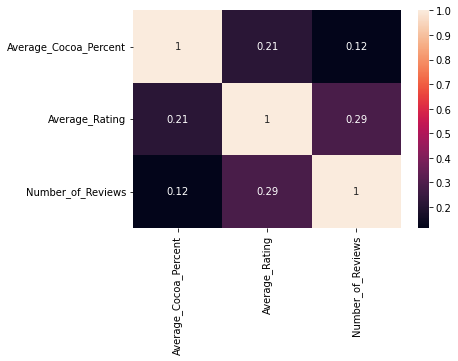

In [43]:
sns.heatmap(correlation_matrix, annot=True)

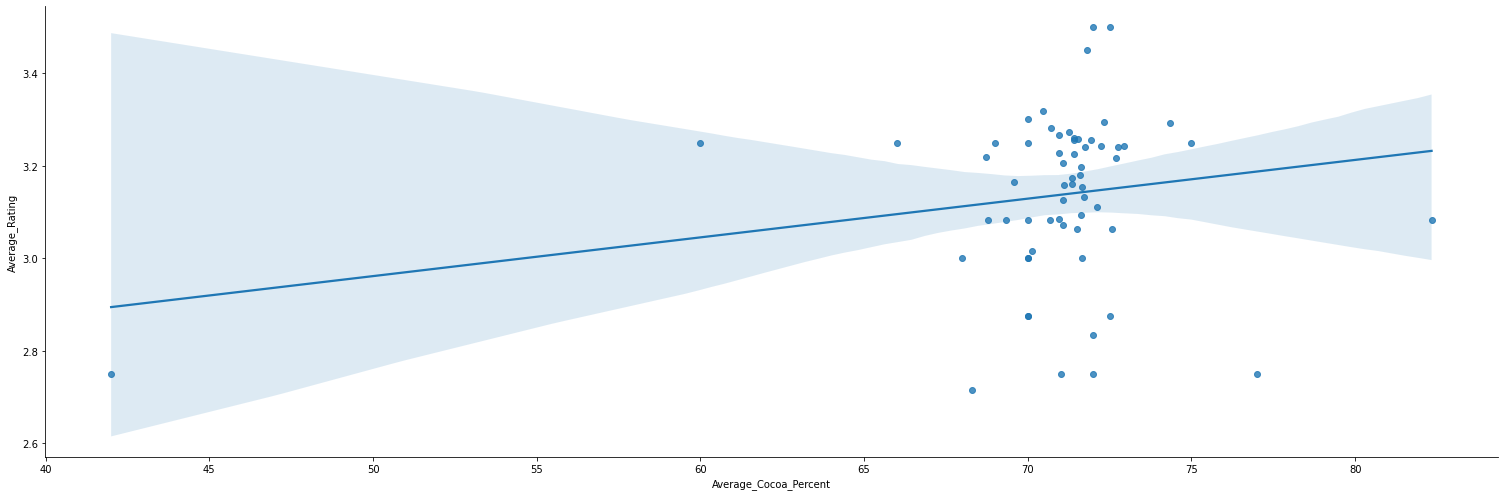

In [45]:
sns.lmplot(x='Average_Cocoa_Percent', y='Average_Rating', data=av_cocoa_rating_origin_df, height=7, aspect=3)

After displaying this results, I can tell that the average cocoa percent is even less relevant to the ratings than the number of reviews.

In [71]:
print('COCOA CONTENT FOR BARS WITH RATING HIGHER THAN 3.5\n')
print('Average: {}'.format(df[df.Rating >= 3.5]['Cocoa_Percent'].mean()))
print('Mode: {}'.format(df[df.Rating >= 3.5]['Cocoa_Percent'].mode()))
print('Median: {}'.format(df[df.Rating >= 3.5]['Cocoa_Percent'].median()))

COCOA CONTENT FOR BARS WITH RATING HIGHER THAN 3.5

Average: 71.1264367816092
Mode: 0    70.0
Name: Cocoa_Percent, dtype: float64
Median: 70.0


If we consider more than 3.5 as the best range of ratings, then the best quantity of cocoa percent is a value between 70 and 71. 

To be more certain, I'm going to get the average ratings of chocolate bars with a cocoa percent in the range of 70 and 71.

In [69]:
print('RATINGS FOR BARS WITH COCOA CONTENT BETWEEN 70 AND 71\n')
print('Average: {}'.format(df[(df.Cocoa_Percent >= 70) & (df.Cocoa_Percent <= 71)]['Rating'].mean()))
print('Mode: {}'.format(df[(df.Cocoa_Percent >= 70) & (df.Cocoa_Percent <= 71)]['Rating'].mode()))
print('Median: {}'.format(df[(df.Cocoa_Percent >= 70) & (df.Cocoa_Percent <= 71)]['Rating'].median()))

RATINGS FOR BARS WITH COCOA CONTENT BETWEEN 70 AND 71

Average: 3.266808712121212
Mode: 0    3.5
Name: Rating, dtype: float64
Median: 3.25


There are a wide range of ratings for chocolate bars with cocoa percent between 70 and 71, however out of this wide range the most repeated value (mode) is 3.5. This means that even though there are a lot of chocolate bars with cocoa percent between 70 and 71 that have lower rating, it is very likely that if the 


**ASK MADALINA AND MADHU**

### 4. Average Rating of Bars Containing Lecithin (L)

**TO DO** 
- Your research indicates that some consumers want to avoid bars with lecithin. Compare the average rating of bars with and without lecithin (L in the ingredients).

#### Resources
- Geo Json: https://datahub.io/core/geo-countries